In [218]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

df = pd.read_csv('spambase.csv')
data = np.array(df.values)
data_0 = np.argwhere(data[:,-1]==0)
data_0 = data_0.reshape(data_0.shape[0],)
data_1 = np.argwhere(data[:,-1]==1)
data_1 = data_1.reshape(data_1.shape[0],)
np.random.shuffle(data_0)
np.random.shuffle(data_1)
arg_train = np.concatenate((data_0[:int(data_0.shape[0]*9//10)], data_1[:int(data_1.shape[0]*9//10)]))
arg_val = np.concatenate((data_0[int(data_0.shape[0]*9//10):], data_1[int(data_1.shape[0]*9//10):]))
train = data[arg_train]
val = data[arg_val]

In [219]:
###1###
train_mean_0 = np.mean(train[(train[:,-1]==0)], axis=0)
train_var_0 = np.var(train[(train[:,-1]==0)], axis=0)
train_mean_1 = np.mean(train[(train[:,-1]==1)], axis=0)
train_var_1 = np.var(train[(train[:,-1]==1)], axis=0)
prob_0 = np.exp(-(val[:,:-1]-train_mean_0[:-1])/(2*(train_var_0[:-1])))/np.sqrt(2*np.pi*(train_var_0[:-1]))
prob_1 = np.exp(-(val[:,:-1]-train_mean_1[:-1])/(2*(train_var_1[:-1])))/np.sqrt(2*np.pi*(train_var_1[:-1]))
p_0 = np.sum(train[:,-1]==1)/train.shape[0]
p_1 = 1 - p_0
pr_1 = p_1*np.prod(prob_1, axis=1)
pr_0 = p_0*np.prod(prob_0, axis=1)
prob_spam = pr_0/(pr_1 + pr_0)
res = prob_spam<0.5
print("val error: " + str(np.sum(np.abs(res-val[:,-1]))/val.shape[0]))

val error: 0.216919739696


In [220]:
def drawFpTp(prob_spam, val):    
    pr = {}
    A = np.unique(prob_spam)
#     A = prob_spam
    
    for a in A:
        res_val = prob_spam<=a
        fp = np.sum(1-val[res_val, -1])
        tn = np.sum(1-val[np.where(res_val, False, True), -1])
        fpr = fp/(fp + tn)
        tp = np.sum(val[res_val, -1])
        fn = np.sum(val[np.where(res_val, False, True), -1])
        tpr = tp / (tp + fn)
        pr[fpr] = tpr
    sork = np.sort(list(pr.keys()))
    val_t = []
    for k in sork:
        val_t.append(pr[k])
    plt.plot(sork, val_t, color='r')

    plt.ylim(ymax=1.01, ymin=0.0)
    plt.xlim(xmax=1.0, xmin=0.0)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

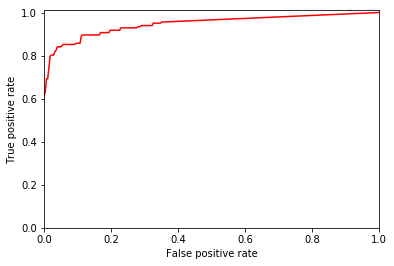

In [221]:
drawFpTp(prob_spam, val)

In [321]:
###2### WRONG
df_sms = pd.read_csv('smsspam.csv')

In [452]:
len(arg_val_sms)

558

In [408]:
data_0_sms = np.argwhere((df_sms["label"]=="ham").values)
data_0_sms = data_0_sms.reshape(data_0_sms.shape[0],)
data_1_sms = np.argwhere((df_sms["label"]=="spam").values)
data_1_sms = data_1_sms.reshape(data_1_sms.shape[0],)
np.random.shuffle(data_0_sms)
np.random.shuffle(data_1_sms)
# arg_train_sms = np.concatenate((data_0_sms[:int(data_0_sms.shape[0]*9//10)], data_1_sms[:int(data_1_sms.shape[0]*9//10)]))
arg_train_sms_0 = data_0_sms[:int(data_0_sms.shape[0]*9//10)]
arg_train_sms_1 = data_1_sms[:int(data_1_sms.shape[0]*9//10)]
arg_val_sms = np.concatenate((data_0_sms[int(data_0_sms.shape[0]*9//10):], data_1_sms[int(data_1_sms.shape[0]*9//10):]))
train_sms_0 = df_sms["text"][arg_train_sms_0]
train_sms_1 = df_sms["text"][arg_train_sms_1]
val_sms = df_sms["text"][arg_val_sms]
val_sms_spam = df_sms["label"][arg_val_sms]=="spam"

In [497]:
print(len(data_1_sms))

747


In [463]:
train_dict_0 = {}
dif_w = {}
dt_0 = 0
dt_1 = 0
for phrase in train_sms_0:
    for word in phrase.split():
        word = word.replace("!","").replace(".","").replace(",","").replace("?","").replace(":","").replace(";","").replace("'","").replace('"','')
        if word in train_dict_0:
            train_dict_0[word] += 1
        else:
            train_dict_0[word] = 1
            dif_w[word] = 1
        dt_0 += 1
            
train_dict_1 = {}
for phrase in train_sms_1:
    for word in phrase.split():
        word = word.replace("!","").replace(".","").replace(",","").replace("?","").replace(":","").replace(";","").replace("'","").replace('"','')
        if word in train_dict_1:
            train_dict_1[word] += 1
        else:
            train_dict_1[word] = 1
            dif_w[word] = 1
        dt_1 += 1
            

In [464]:
K = len(dif_w.keys())
pr_0 = len(train_sms_0)/(len(train_sms_0) + len(train_sms_1))
pr_1 = 1 - pr_0

In [525]:
prob_val = []
ind_val = []
for ind, phrase in val_sms.items():
    p_0 = 1
    p_1 = 1
    for word in phrase.split():
        word = word.replace("!","").replace(".","").replace(",","").replace("?","").replace(":","").replace(";","").replace("'","").replace('"','')
        if word in dif_w.keys():
            if word in train_dict_0:
                p_0 *= (train_dict_0[word]+1)/(dt_0+K)
            else:
                p_0 *= 1/(dt_0+K)
            if word in train_dict_1:
                p_1 *= (train_dict_1[word]+1)/(dt_1+K)
            else:
                p_1 *= 1/(dt_1+K)
    p_0 *= pr_0
    p_1 *= pr_1
    try:
        prob_val.append(p_0/(p_0+p_1))
        ind_val.append(ind)
    except:
        prob_val.append(pr_0)
        ind_val.append(ind)

In [539]:
def drawFpTp(prob_spam, val):    
    pr = {}
    A = np.unique(prob_spam)
    for a in A:
        res_val = prob_spam>a
        fp = np.sum(1-val[res_val])
        tn = np.sum(1-val[np.where(res_val, False, True)])
        fpr = fp/(fp + tn)
        tp = np.sum(val[res_val])
        fn = np.sum(val[np.where(res_val, False, True)])
        tpr = tp / (tp + fn)
        pr[fpr] = tpr
    sork = np.sort(list(pr.keys()))
    val_t = []
    for k in sork:
        val_t.append(pr[k])
    plt.plot(sork, val_t, color='r')

    plt.ylim(ymax=1.01, ymin=0.0)
    plt.xlim(xmax=1.0, xmin=0.0)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

In [540]:
val_res = df_sms["label"][ind_val]=="ham"

In [542]:
val_res = np.array(val_res.values)
pr_val = np.array(prob_val)

In [543]:
rs = pr_val > 0.5

In [547]:
print("error val: " + str(np.sum(rs^val_res)/len(val_res)))

error val: 0.010752688172


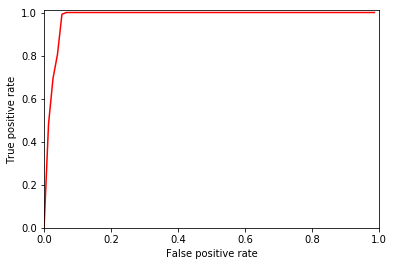

In [548]:
drawFpTp(pr_val, val_res)